In [2]:
m = pyqg.QGModel(nx=64, log_level=0, dt=3600., tmax=50000*3600)
m.run()

In [1]:
import xarray as xr
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import pyqg_subgrid_experiments as pse
import pyqg
import matplotlib.pyplot as plt
%matplotlib inline

In [143]:
import importlib
importlib.reload(pse.dataset)
importlib.reload(pse)

<module 'pyqg_subgrid_experiments' from '/home/asr9645/pyqg_experiments/pyqg_subgrid_experiments/__init__.py'>

In [144]:
train = pse.Dataset(m)
train['a'] = train.u**2 + train.v**2 - 2*train.u*train.v + 0.1*train.curl('u','v')
ds=train

In [163]:
class BatchSymbolicRegression(nn.Module):
    def __init__(self, features, target):
        super().__init__()
        self.features = features
        self.target = target
        self.initialize_weights()
        
    def initialize_weights(self):
        self.weights = nn.Parameter(torch.zeros(len(self.features)))
        self.bias = nn.Parameter(torch.zeros(1)[0])
        
    def forward(self, x):
        return (self.weights * x).sum(dim=1) + self.bias
    
    def as_tensor(self, x):
        return torch.tensor(x.astype(np.float32))
    
    def extract_x(self, ds):
        return self.as_tensor(np.stack([
            ds.extract_feature(f).data.ravel() for f in self.features
        ], axis=1))
    
    def extract_y(self, ds):
        return self.as_tensor(ds.extract_feature(self.target).data.ravel())
    
    def fit(self, ds, learning_rate=0.001, num_epochs=50):
        if 'run' not in ds.dims: ds = ds.expand_dims('run')
        if 'time' not in ds.dims: ds = ds.expand_dims('time')
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(num_epochs/2), int(num_epochs*3/4), int(num_epochs*7/8)], gamma=0.1)
        criterion = nn.MSELoss()
        for epoch in range(num_epochs):
            epoch_loss = 0.0
            epoch_steps = 0
            runs = np.arange(len(ds.run)); np.random.shuffle(runs)
            time = np.arange(len(ds.time)); np.random.shuffle(time)
            for t in time:
                for r in runs:
                    batch = ds.isel(run=r, time=t)
                    x = self.extract_x(batch)
                    y = self.extract_y(batch)
                    optimizer.zero_grad()
                    yhat = self.forward(x)
                    loss = criterion(yhat, y)
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
                    epoch_steps += 1
            print(f"Loss after Epoch {epoch+1}: {epoch_loss/epoch_steps}")
            scheduler.step()
    

        

In [164]:
sr = BatchSymbolicRegression(
  ['u','v','mul(u,u)','mul(v,v)','mul(u,v)','curl(u,v)','div(u,v)'],
'a'
)
sr.parameters()

<generator object Module.parameters at 0x150b3b2f4740>

In [180]:
sr.fit(train, learning_rate=0.01, num_epochs=100)

Loss after Epoch 1: 1.5702585898225152e-08
Loss after Epoch 2: 9.77532981778495e-05
Loss after Epoch 3: 6.01689725954202e-06
Loss after Epoch 4: 2.208326077379752e-05
Loss after Epoch 5: 5.713508289773017e-05
Loss after Epoch 6: 4.2315754399169236e-05
Loss after Epoch 7: 1.1659955816867296e-05
Loss after Epoch 8: 1.3580437041582627e-07
Loss after Epoch 9: 1.261747456737794e-05
Loss after Epoch 10: 2.7205147489439696e-05
Loss after Epoch 11: 2.599668914626818e-05
Loss after Epoch 12: 1.2804805919586215e-05
Loss after Epoch 13: 1.6122321540024132e-06
Loss after Epoch 14: 1.3755770851275884e-06
Loss after Epoch 15: 9.205969035974704e-06
Loss after Epoch 16: 1.5048097338876687e-05
Loss after Epoch 17: 1.2937950486957561e-05
Loss after Epoch 18: 5.764168690802762e-06
Loss after Epoch 19: 4.944477041135542e-07
Loss after Epoch 20: 1.1247067277508904e-06
Loss after Epoch 21: 5.5129462452896405e-06
Loss after Epoch 22: 8.319086191477254e-06
Loss after Epoch 23: 6.7223322730569635e-06
Loss afte

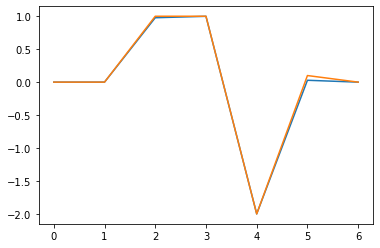

In [181]:
plt.plot(sr.weights.data.numpy())
plt.plot([0,0,1,1,-2,0.1,0])

In [168]:
sr.bias.data.numpy()

array(0.00218319, dtype=float32)

In [140]:
sr.forward(sr.extract_x(ds)).shape

torch.Size([8192])

In [141]:
sr(sr.extract_x(ds))

tensor([0., 0., 0.,  ..., 0., 0., 0.], grad_fn=<AddBackward0>)

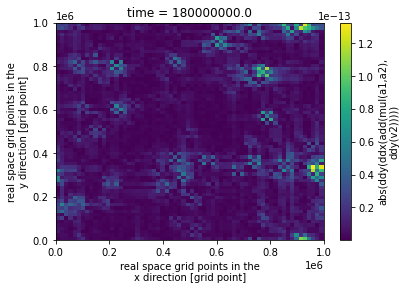

In [80]:
f = train.extract_feature('abs(ddy(ddx(add(mul(a1,a2), ddy(v2)))))')
f.plot()